In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt

from uproot_io import Events, View
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

# Define data sets

SK Learn provides functions to generate data sets for testing purposes, in this case via the make_classification it generates 2D points (features) belonging to two different clusters based. 2D points were chosen here for ease of visualisation, but the number of variables can be extended arbitrarily to suit your needs.

Three data sets are generated from the same underlying distribution, simply using different random seeds. One is the training set for the BDT, the remaining two are validation and test sets. I won't use the validation set here, but if you tune your BDT based on it's performance on a 'test' set, you're effectively turning your test set into a training set, this is the role of the validation set and so final evaluation of the BDT performance should be done using the test set, which should have played no role in training or defining the hyper parameters of the BDT.

In [15]:
# need training features as [[1,2,3,4,5],[1,2,3,4,5],...] and training labels as [6,6,6,6,6,...],
# same format for testing data

In [16]:
events = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")

In [17]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")

In [18]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def coords(event_number):
    idx = np.where(events.event_number == event_number)[0]
    
    # line of best fit
    gradients = []
    intercepts = []
    
    # particle labels
    particle_type = []
    
    # features
    proximal_hits = []
    standard_deviation = []
    hits_per_length = []
    energy = []
    mean_connection = []
    
    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    for i in idx:
        
        # hits, pdg code, purity, completeness, adc values, vertex coordinates
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        purity = events.purity[i]
        complete = events.completeness[i]
        
        adc = events.reco_adcs_w[i]
        vx = events.reco_particle_vtx_x[i]
        vz = events.reco_particle_vtx_w[i]
        
        # cuts made for clean data
        if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
            
            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 100

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                
                gradients.append(m)
                intercepts.append(c)
                
                # recording the particle pdg code
                particle_type.append(pdg)
                
                # changing the coordinates into longitudinal and tranverse from best line
                
                znew = z - c
                angle = -math.atan(m)
                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)
                
                # feature 1: proximal hits within 5% of transverse range of the hits.
                
                tdiff = np.abs(max(t)-min(t))
                margin = tdiff*0.05
                inside = [x for x in t if x <= margin and x >= -margin]
                proximal_hits.append(len(inside)/len(t))
                
                # feature 2: the standard deviation of the last 30% of a topology
                
                p1 = int(0.7 * len(t))
                X = t[p1:]
                Xvar = np.var(X)
                
                p2 = int(0.3 * len(t))
                Y = t[:p2]
                Yvar = np.var(Y)
                
                if  Yvar > Xvar:
                    resultY = np.sqrt(Yvar)
                    standard_deviation.append(resultY)           
                else:
                    resultX = np.sqrt(Xvar)
                    standard_deviation.append(resultX)
                
                # feature 3: the hits per length
                
                above = np.sum(t > 0)
                below = np.sum(t < 0)
                
                lmin, lmax = np.min(l), np.max(l)
                length = lmax - lmin

                if above == 0 or below == 0 or length == 0:
                    hits_per_length.append(2)
                    
                else:
                    # If symmetric, this should be close to 1, otherwise > 1
                    hits = (above + below) / length
                    hits_per_length.append(sym)
            
                
                # feature 4: energy in the last 10% of the track
                
                vznew = vz - c
                
                vl = vx * np.cos(angle) - vznew * np.sin(angle)
                vt = vx * np.sin(angle) + vznew * np.cos(angle)
                
                if max(l) < vl:
                    l *= -1
                    
                combined = list(zip(l, t, adc))
                sort = sorted(combined, key = lambda coord: coord[0])
                
                lnew, tnew, adcnew = zip(*sort)
                
                percent = int(0.9 * len(adcnew))
                X = adcnew[percent:]
                Xsum = np.sum(X)

                total = np.sum(adcnew)
                result = Xsum / total

                energy.append(result)
                
                # feature 5: mean connection distance
                
                total_distance = 0.0
                for j in range(len(x) - 1):
                    distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                    total_distance += distance
                meandist = total_distance/(len(x)-1)
                mean_connection.append(meandist)
                
            
            else:
                proximal_hits.append(0.1)
                standard_deviation.append(1.5)
                hits_per_length.append(2)
                energy.append(0.25)
                particle_type.append(pdg)
                
    
    return particle_type, proximal_hits, standard_deviation, hits_per_length, E

In [53]:
# training data

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def BDTdata():
    data = []
    label = []
    
    for n in training: 
        
        idx = np.where(events.event_number == n)[0]

        # line of best fit
        gradients = []
        intercepts = []

        xmax = -1000
        xmin = 1000
        zmax = -1000
        zmin = 1000
        for i in idx:
            x0 = events.reco_hits_x_w[i]
            z0 = events.reco_hits_w[i]
            if len(x0) > 0:
                if max(x0) >= xmax:
                    xmax = max(x0)
                if min(x0) <= xmin:
                    xmin = min(x0)
            if len(z0) > 0:
                if max(z0) >= zmax:
                    zmax = max(z0)
                if min(z0) <= zmin:
                    zmin = min(z0)

        xlen = 0.1*(xmax - xmin)
        zlen = 0.1*(zmax - zmin)

        for i in idx:
            
            # features
            entry = []
            
            # hits, pdg code, purity, completeness, adc values, vertex coordinates

            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]

            adc = events.reco_adcs_w[i]
            vx = events.reco_particle_vtx_x[i]
            vz = events.reco_particle_vtx_w[i]
            
            party = []

            # cuts made for clean data
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                party.append(pdg)
                
            for q in range(len(party)):
                if party[q] == 22. or party[q] == -11. or party[q] == 11.:
                    label.append(0) # showers
                else:
                    label.append(1) # tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                
                best_inliers = []
                best_model = None
                sample_size = 10
                max_iterations = 100

                for _ in range(max_iterations):
                    sample_size = min(sample_size, len(x))
                    sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                    x_sample = x[sample_indices]
                    z_sample = z[sample_indices]

                    m, c = fit_line(x_sample, z_sample)
                    residuals = calculate_residuals(x, z, m, c)
                    inliers = np.where(residuals < (0.15*xlen))[0]

                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_model = (m, c)

                if len(best_inliers) > 0:
                    m, c = best_model

                    gradients.append(m)
                    intercepts.append(c)

                    # changing the coordinates into longitudinal and tranverse from best line

                    znew = z - c
                    angle = -math.atan(m)
                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    # feature 1: proximal hits within 5% of transverse range of the hits.

                    tdiff = np.abs(max(t)-min(t))
                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    entry.append(len(inside)/len(t))

                    # feature 2: the standard deviation of the last 30% of a topology

                    p1 = int(0.7 * len(t))
                    X = t[p1:]
                    Xvar = np.var(X)

                    p2 = int(0.3 * len(t))
                    Y = t[:p2]
                    Yvar = np.var(Y)

                    if  Yvar > Xvar:
                        resultY = np.sqrt(Yvar)
                        entry.append(resultY)           
                    else:
                        resultX = np.sqrt(Xvar)
                        entry.append(resultX)

                    # feature 3: the hits per length

                    above = np.sum(t > 0)
                    below = np.sum(t < 0)

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    if above == 0 or below == 0 or length == 0:
                        entry.append(2)

                    else:
                        # If symmetric, this should be close to 1, otherwise > 1
                        hits = (above + below) / length
                        entry.append(hits)


                    # feature 4: energy in the last 10% of the track

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.9 * len(adcnew))
                    X = adcnew[percent:]
                    Xsum = np.sum(X)

                    total = np.sum(adcnew)
                    result = Xsum / total

                    entry.append(result)

                    # feature 5: mean connection distance

                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    entry.append(meandist)
                    data.append(entry)


                else:
                    entry.append(0.1)  # proximal hits
                    entry.append(1.5)  # standard deviation
                    entry.append(2)    # hits per length
                    entry.append(0.25) # energy
                    entry.append(1)    # mean connection distance
                    data.append(entry)
    
    return data, label

In [47]:
data, label = BDTdata()

In [51]:
x_train = data
y_train = label

In [56]:
# testing

def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def BDTtestData():
    data = []
    label = []
    
    for n in testing: 
        
        idx = np.where(events.event_number == n)[0]

        # line of best fit
        gradients = []
        intercepts = []

        xmax = -1000
        xmin = 1000
        zmax = -1000
        zmin = 1000
        for i in idx:
            x0 = events.reco_hits_x_w[i]
            z0 = events.reco_hits_w[i]
            if len(x0) > 0:
                if max(x0) >= xmax:
                    xmax = max(x0)
                if min(x0) <= xmin:
                    xmin = min(x0)
            if len(z0) > 0:
                if max(z0) >= zmax:
                    zmax = max(z0)
                if min(z0) <= zmin:
                    zmin = min(z0)

        xlen = 0.1*(xmax - xmin)
        zlen = 0.1*(zmax - zmin)

        for i in idx:
            
            # features
            entry = []
            
            # hits, pdg code, purity, completeness, adc values, vertex coordinates

            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]

            adc = events.reco_adcs_w[i]
            vx = events.reco_particle_vtx_x[i]
            vz = events.reco_particle_vtx_w[i]
            
            party = []

            # cuts made for clean data
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                party.append(pdg)
                
            for q in range(len(party)):
                if party[q] == 22. or party[q] == -11. or party[q] == 11.:
                    label.append(0) # showers
                else:
                    label.append(1) # tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                
                best_inliers = []
                best_model = None
                sample_size = 10
                max_iterations = 100

                for _ in range(max_iterations):
                    sample_size = min(sample_size, len(x))
                    sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                    x_sample = x[sample_indices]
                    z_sample = z[sample_indices]

                    m, c = fit_line(x_sample, z_sample)
                    residuals = calculate_residuals(x, z, m, c)
                    inliers = np.where(residuals < (0.15*xlen))[0]

                    if len(inliers) > len(best_inliers):
                        best_inliers = inliers
                        best_model = (m, c)

                if len(best_inliers) > 0:
                    m, c = best_model

                    gradients.append(m)
                    intercepts.append(c)

                    # changing the coordinates into longitudinal and tranverse from best line

                    znew = z - c
                    angle = -math.atan(m)
                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    # feature 1: proximal hits within 5% of transverse range of the hits.

                    tdiff = np.abs(max(t)-min(t))
                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    entry.append(len(inside)/len(t))

                    # feature 2: the standard deviation of the last 30% of a topology

                    p1 = int(0.7 * len(t))
                    X = t[p1:]
                    Xvar = np.var(X)

                    p2 = int(0.3 * len(t))
                    Y = t[:p2]
                    Yvar = np.var(Y)

                    if  Yvar > Xvar:
                        resultY = np.sqrt(Yvar)
                        entry.append(resultY)           
                    else:
                        resultX = np.sqrt(Xvar)
                        entry.append(resultX)

                    # feature 3: the hits per length

                    above = np.sum(t > 0)
                    below = np.sum(t < 0)

                    lmin, lmax = np.min(l), np.max(l)
                    length = lmax - lmin

                    if above == 0 or below == 0 or length == 0:
                        entry.append(2)

                    else:
                        # If symmetric, this should be close to 1, otherwise > 1
                        hits = (above + below) / length
                        entry.append(hits)


                    # feature 4: energy in the last 10% of the track

                    vznew = vz - c

                    vl = vx * np.cos(angle) - vznew * np.sin(angle)
                    vt = vx * np.sin(angle) + vznew * np.cos(angle)

                    if max(l) < vl:
                        l *= -1

                    combined = list(zip(l, t, adc))
                    sort = sorted(combined, key = lambda coord: coord[0])

                    lnew, tnew, adcnew = zip(*sort)

                    percent = int(0.9 * len(adcnew))
                    X = adcnew[percent:]
                    Xsum = np.sum(X)

                    total = np.sum(adcnew)
                    result = Xsum / total

                    entry.append(result)

                    # feature 5: mean connection distance

                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    entry.append(meandist)
                    data.append(entry)


                else:
                    entry.append(0.1)  # proximal hits
                    entry.append(1.5)  # standard deviation
                    entry.append(2)    # hits per length
                    entry.append(0.25) # energy
                    entry.append(1)    # mean connection distance
                    data.append(entry)
    
    return data, label

In [57]:
x_test, y_test = BDTtestData()

In [60]:
len(x_test), len(y_test)

(13358, 13358)

# Training set features

x_train contains 1000 samples of 2 features, which we'll interpret as positions, you'll want to define samples based on variables you think are interesting for your classification problem

In [58]:
x_train

[[0.7201834862385321,
  10.726126,
  3.5145906757190417,
  0.06853209,
  5.143666686172369],
 [0.7446808510638298,
  9.791365,
  1.6467018297566134,
  0.07581695,
  4.014172649591185],
 [0.7519083969465649,
  13.024633,
  2.4427069462748876,
  0.055026703,
  6.347971620715404],
 [0.1794871794871795,
  0.18227522,
  1.6448804070395289,
  0.16111809,
  0.6249674058182776],
 [0.4, 0.592613, 0.2716802202427176, 0.075264685, 4.642372869473431],
 [0.19010416666666666,
  3.5889838,
  1.4285465166971838,
  0.14986828,
  0.7259191720760142],
 [0.35, 1.1243345, 0.9620528177801265, 0.056620277, 5.616116654664498],
 [0.7956204379562044,
  10.891005,
  3.7757316352109593,
  0.07290607,
  5.366524945586597],
 [0.22916666666666666,
  0.050152615,
  2.03247328029235,
  0.095223784,
  0.5001224223556517],
 [0.5849056603773585,
  0.67222273,
  2.1022757351754415,
  0.17676622,
  0.48016859755049496],
 [0.2926829268292683,
  0.11370942,
  1.3997795757259903,
  0.17429309,
  0.7424534675779555],
 [0.73333

# Training set labels

y_train contains the corresponding labels for each of the samples, in this case, class 0 or class 1, in your case this might represent track or shower, or alternatively some set of particle ids

In [59]:
y_train

[0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,


# Creating and training the BDT

Now we can create the BDT itself. The BDT (AdaBoostClassifier) will be composed of many base trees (DecisionTreeClassifier). This is essentially the default set up for a BDT, you can find details of the arguments used here and many other hyper-parameters (essentially the parameters that describe the structure of the tree, rather than physics variables) via the SK learn documentation. Note comparing the performance of your BDT for different values of max-depth, for example, is the sort of task you would perform (after training) with the validation set, and once you've settled on a 'best' set of hyper-parameters, then you would perform a final evaluation of that tree using the test set.

Having defined the tree in these first two, the next step is to train the BDT by simply calling the fit function and supplying the training features (x_train) and labels (y_train).

In [61]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=4)
bdt = AdaBoostClassifier(base_estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

/Users/mohammed/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   n_estimators=100, random_state=0)

# Checking the classification performance

Once trained, we can evaluate the performance of the BDT. First you can see how well the BDT was actually able to fit the training data - if there's no predictive power in your features, or insufficient degrees of freedom in your BDT, no amount of training will yield anything useful. In this case we can see that the classification accuracy for this default BDT is pretty good, classifiying about 92% of points correctly

In [62]:
# Check the training set classification performance
bdt.score(x_train, y_train)

0.9984956630285184

/var/folders/0j/k5n00ph57w3c1tdfq0lwsgn00000gn/T/ipykernel_4556/2627674318.py:5: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  cls_0_f = f[np.where(y_train == 0)]
/var/folders/0j/k5n00ph57w3c1tdfq0lwsgn00000gn/T/ipykernel_4556/2627674318.py:6: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  cls_1_f = f[np.where(y_train == 1)]


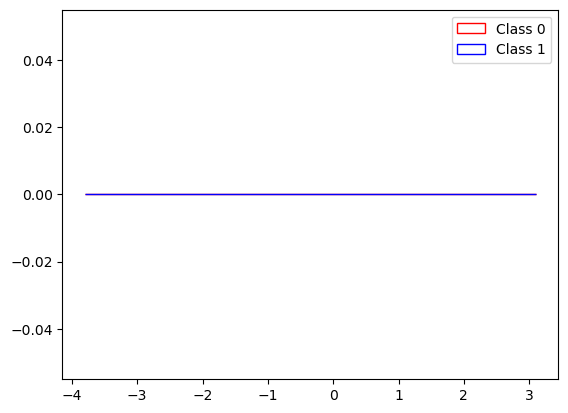

In [63]:
f = bdt.decision_function(x_train)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
cls_0_f = f[np.where(y_train == 0)]
cls_1_f = f[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1')
plt.legend()

If you're happy with your training sample performance, you can move on to evaluating on a sample your BDT hasn't seen before. I'm not going to do any tuning, so I'll move straight to the test set. We can see that the classification performance is about 85%, which is not bad, but may indicate overfitting. This may be due to an insufficiently large training set (and thereby potentially unrepresenative of the underlying distribution), or it could be that the BDT has too many degrees of freedom and is therefore learning how to predict the specific case seen in the training set, rather than the more general case.

This is where you may want to review sample size, or hyper-parameters of your tree.

In [64]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.9687827519089685

# Visualising the classification

It can be very useful to visualise the results to understand what's going on, here that's easy because we have 2D features, you will likely have more features, and so may need to pick out subsets of your features for visualisation purposes.

First, we'll get our BDT to predict the classes based on the training set features and plot the classes.

In [9]:
# Get the class predictions for the training set
pred = bdt.predict(x_test)

Now, we'll plot the truth in the training set (left) and the BDT classification of the training set (right).

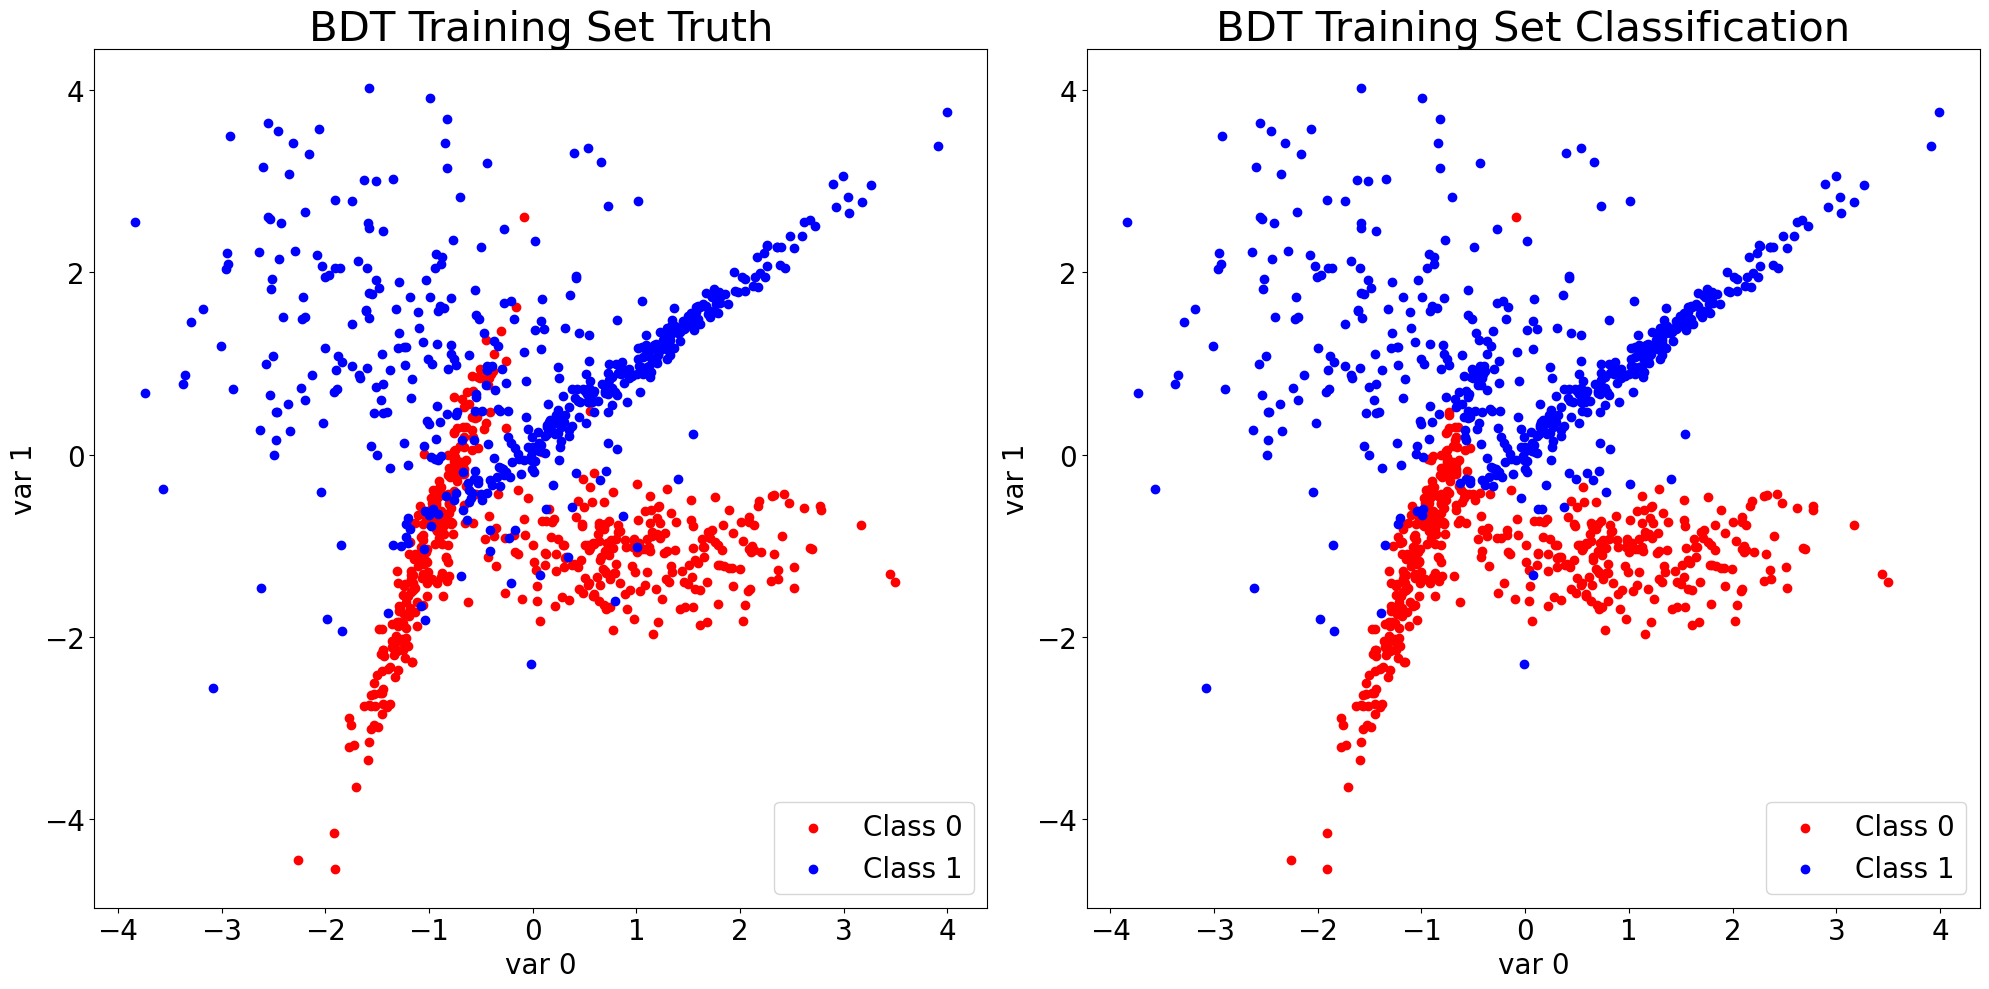

In [10]:
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot the training set
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_train == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_train == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("var 0", fontsize=labelsize)
ax.set_ylabel("var 1", fontsize=labelsize)
ax.set_title("BDT Training Set Truth", fontsize=titlesize)
ax.legend(fontsize=labelsize)
    
# Plot the training set BDT classification
ax = axes[1]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("var 0", fontsize=labelsize)
ax.set_ylabel("var 1", fontsize=labelsize)
ax.set_title("BDT Training Set Classification", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()

As expected for 92% classification accuracy, the plot looks pretty good, but we can identify where things go wrong by identifying the mismatches between truth label and classification label. Here we can see the region in which the tree struggles: essentially the overlap region for the two classes.

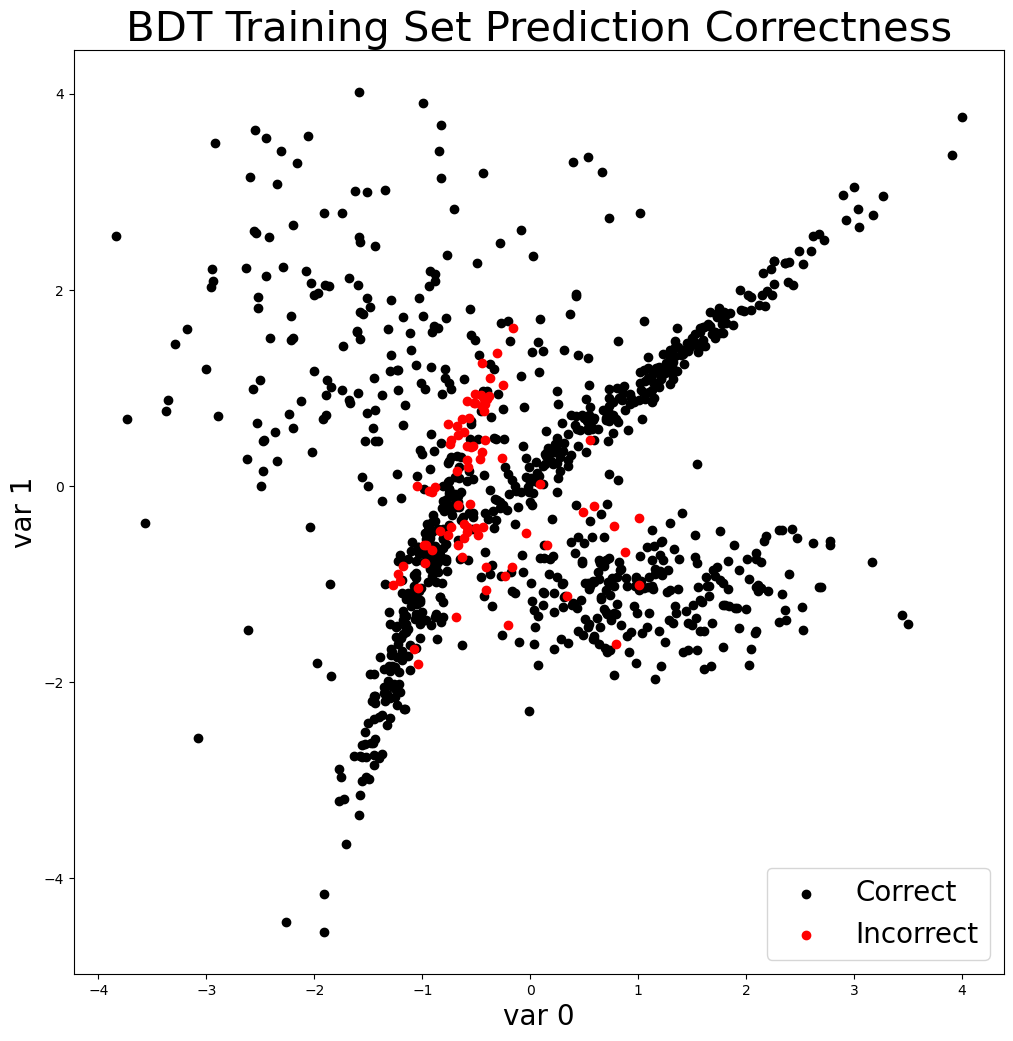

In [11]:
# Plot the test set prediction correctness
plt.figure(figsize=(12, 12))
cls_0 = np.where(pred == y_train)
plt.scatter(x_train[cls_0, 0], x_train[cls_0, 1], c="k", label="Correct")
cls_1 = np.where(pred != y_train)
plt.scatter(x_train[cls_1, 0], x_train[cls_1, 1], c="r", label="Incorrect")
plt.xlabel("var 0", fontsize=labelsize)
plt.ylabel("var 1", fontsize=labelsize)
plt.title("BDT Training Set Prediction Correctness",fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()

# Visualising the test set classification

Now we can repreat the above steps for the test set. So, we'll predict the test set and then look at the test set truth and corresponding classification. While some aspects of the data set are similar to our training set, there are some notable differences too, so maybe our training set wasn't large enough to be representative.

If we look at the classification, one region in particular stands out in the bottom left quadrant.

In [12]:
# Get the class predictions for the test set
pred = bdt.predict(x_test)

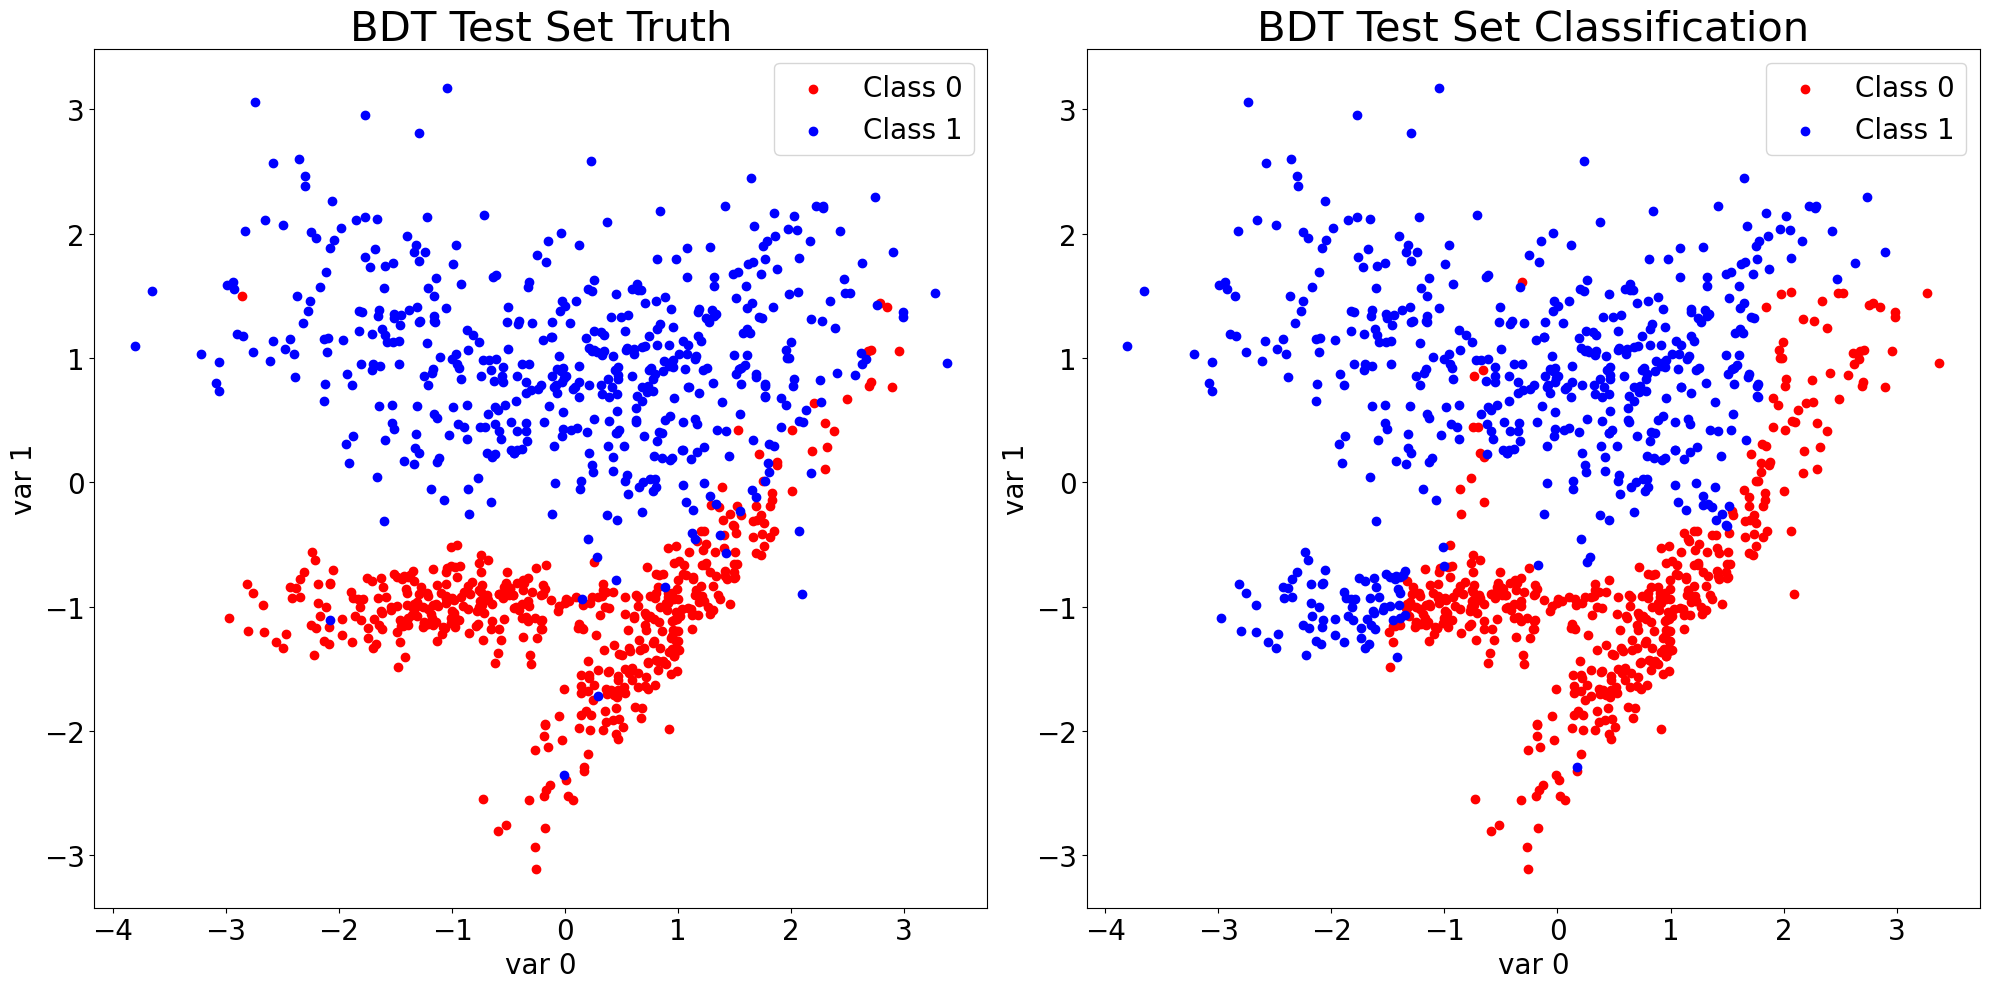

In [13]:
titlesize = 30
labelsize = 20
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot the test set
ax = axes[0]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(y_test == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(y_test == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("var 0", fontsize=labelsize)
ax.set_ylabel("var 1", fontsize=labelsize)
ax.set_title("BDT Test Set Truth", fontsize=titlesize)
ax.legend(fontsize=labelsize)
    
# Plot the test set BDT classification
ax = axes[1]
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
cls_0 = np.where(pred == 0)
ax.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="r", label="Class 0")
cls_1 = np.where(pred == 1)
ax.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="b", label="Class 1")
ax.set_xlabel("var 0", fontsize=labelsize)
ax.set_ylabel("var 1", fontsize=labelsize)
ax.set_title("BDT Test Set Classification", fontsize=titlesize)
ax.legend(fontsize=labelsize)

fig.tight_layout()

Looking in particular at the mismatches highlights what was already pretty obvious - a region of class 0 hits that had little-to-no corresponding cases in the training set.

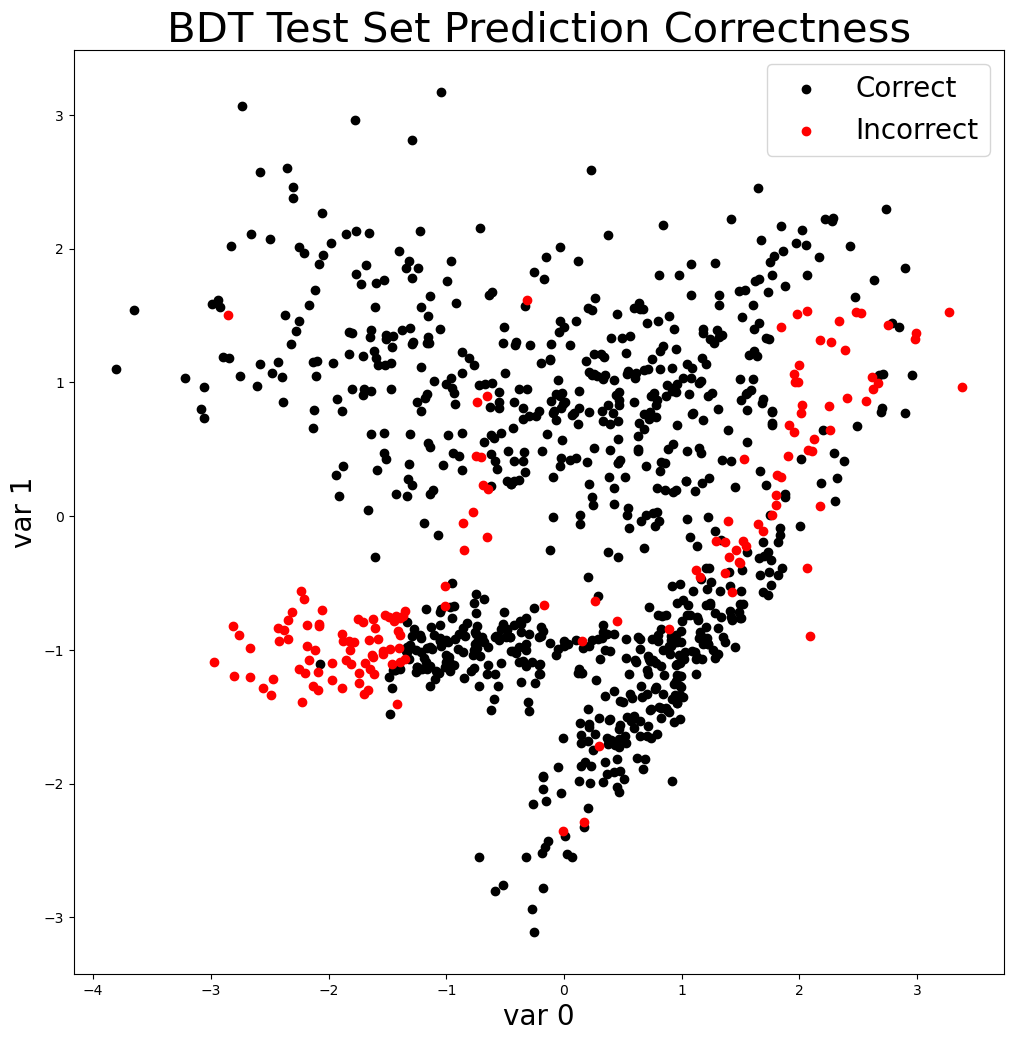

In [14]:
# Plot the test set prediction correctness
plt.figure(figsize=(12, 12))
cls_0 = np.where(pred == y_test)
plt.scatter(x_test[cls_0, 0], x_test[cls_0, 1], c="k", label="Correct")
cls_1 = np.where(pred != y_test)
plt.scatter(x_test[cls_1, 0], x_test[cls_1, 1], c="r", label="Incorrect")
plt.xlabel("var 0", fontsize=labelsize)
plt.ylabel("var 1", fontsize=labelsize)
plt.title("BDT Test Set Prediction Correctness", fontsize=titlesize)
plt.legend(fontsize=labelsize)
plt.show()